# Denoising proteomics - data exploration

In [1]:
import os
from config import FN_PROTEIN_TSV 
from config import FOLDER_DATA, FIGUREFOLDER

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA

In [3]:
import os
import logging
logger = logging.getLogger()
def _savefig(fig, name, folder=FIGUREFOLDER, pdf=True):
    """Save matplotlib Figure (having method `savefig`) as pdf and png."""
    filename = os.path.join(folder, name)
    fig.savefig(filename + '.png')
    if pdf: fig.savefig(filename + '.pdf')
    logger.info(f"Saved Figures to {filename}")

In [4]:
#coverage
def coverage(X:pd.DataFrame, coverage_col:float, coverage_row:float):
    """Select proteins by column depending on their coverage. 
    Of these selected proteins, where the rows have a certain number of overall proteins.
    """
    mask_col = X.isnull().mean() <= 1-coverage_col
    df = X.loc[:,mask_col]
    mask_row = df.isnull().mean(axis=1) <= 1-coverage_row
    df = df.loc[mask_row,:]
    return df

## Load Data

In [5]:
df = pd.read_table(FN_PROTEIN_TSV, sep = '\t')
df.sort_values(by = ['Date'], inplace = True)

In [6]:
df.head()

,index,Date,MS_instrument,LC,PID,ColumnLength,A0A024QZ33,A0A024QZ42,A0A024QZP7,A0A024QZX5,...,X6RK76,X6RK96,X6RKB4,X6RKL2,X6RKY7,X6RLL4,X6RLN4,X6RLR1,X6RLX0,X6RM59
408,20180713_QE8_nLC5_ASD_QC_Hela1_proteinGroups.txt,20180713,QE8,nLC5,ASD,NaN,46239000.0,NaN,NaN,2.586900e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,20180713_QE8_nLC5_ASD_QC_Hela2_proteinGroups.txt,20180713,QE8,nLC5,ASD,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,20180713_QE8_nLC5_ASD_QC_Hela2_20190226172112_...,20180713,QE8,nLC5,ASD,NaN,NaN,NaN,NaN,3.078800e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_pro...,20190103,QE8,nLC0,LiNi,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_pro...,20190103,QE8,nLC0,LiNi,15.0,NaN,NaN,NaN,6.685000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# import datetime 
# pd.to_datetime(df["Date"],format='%Y%m%d') == datetime.datetime(2019, 4, 22)

### Separate Data into proteome and meta-data

In [8]:
labels = df.iloc[:,0:6]
labels['shortdate']=labels['Date'].astype(str).str[:6]
X = df.iloc[:,6:]  # ToDo: Rename everything from x to X -> code can be (potentially) copy-pasted
X.columns.name = 'proteins'

In [9]:
X.head()

proteins,A0A024QZ33,A0A024QZ42,A0A024QZP7,A0A024QZX5,A0A024R161,A0A024R1R8,A0A024R341,A0A024R368,A0A024R3B9,A0A024R3M2,...,X6RK76,X6RK96,X6RKB4,X6RKL2,X6RKY7,X6RLL4,X6RLN4,X6RLR1,X6RLX0,X6RM59
408,46239000.0,NaN,NaN,2.586900e+09,NaN,7.753100e+08,210280000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3154400.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,NaN,NaN,NaN,3.078800e+09,NaN,1.238300e+09,225030000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,NaN,NaN,NaN,6.685000e+08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
labels.head()

,index,Date,MS_instrument,LC,PID,ColumnLength,shortdate
408,20180713_QE8_nLC5_ASD_QC_Hela1_proteinGroups.txt,20180713,QE8,nLC5,ASD,NaN,201807
312,20180713_QE8_nLC5_ASD_QC_Hela2_proteinGroups.txt,20180713,QE8,nLC5,ASD,NaN,201807
281,20180713_QE8_nLC5_ASD_QC_Hela2_20190226172112_...,20180713,QE8,nLC5,ASD,NaN,201807
82,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_pro...,20190103,QE8,nLC0,LiNi,15.0,201901
161,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_pro...,20190103,QE8,nLC0,LiNi,15.0,201901


### Proteome is sparse
Proteins that are only identified for a minority of samples should be removed

In [11]:
missingness = X.notnull().astype('int')
missingness = missingness[missingness.mean().sort_values().index]
missingness.index.name = 'SampleID'
missingness_index_id = missingness.index.to_frame()
missingness_index_id["DateID"] = labels.Date
missingness.index = labels.Date
missingness.sort_index(inplace=True)

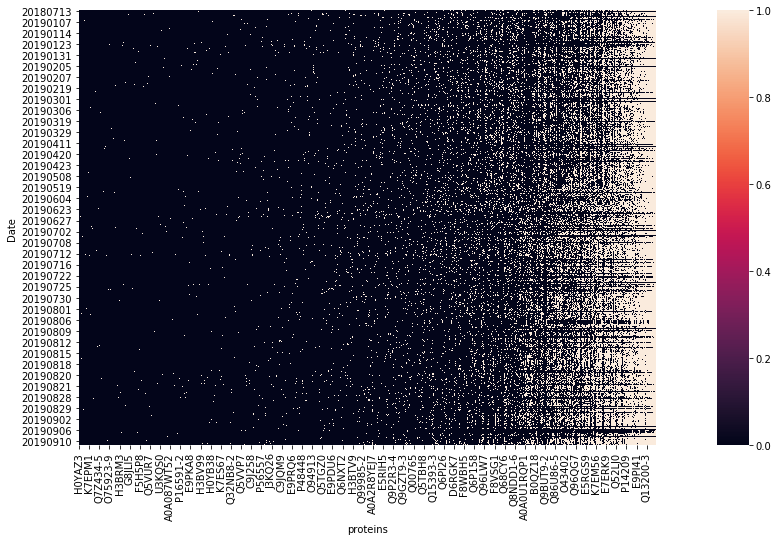

In [12]:
grid_kws = {"width_ratios": (.9, .05), "hspace": 0.5}
fig_heatmap_missing, (axes_heatmap_missing, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(12,8))
axes_heatmap_missing = sns.heatmap(missingness, ax=axes_heatmap_missing,
                                   cbar_ax=cbar_ax,
                                   cbar_kws={"orientation": "vertical"})

In [13]:
# # This currently crashes if you want to have a pdf
_savefig(fig_heatmap_missing, 'proteins_heatmap_missing', pdf=False)

#### Samples have 6 to 4461 identified protein-groups
- cutoff for minimum quality of peptide, e.g. at least 2500 identified proteins?
- Proteome is not consistent over many runs

In [14]:
COL_NO_MISSING_PROT, COL_NO_IDENTIFIED_PROT ='no_missing_proteins_of_proteome', 'no_identified_proteins'
COL_PROP_SAMPLES = 'prop_samples'

sample_stats = missingness.sum(axis=1).to_frame(COL_NO_IDENTIFIED_PROT)
sample_stats[COL_NO_MISSING_PROT] = (missingness == 0).sum(axis=1)

assert all(sample_stats.sum(axis=1) == X.shape[1])
sample_stats = sample_stats.sort_values(by=COL_NO_IDENTIFIED_PROT, ascending=False).reset_index()
sample_stats[COL_PROP_SAMPLES] = np.array(range(1,len(sample_stats)+1)) / len(sample_stats)
sample_stats = sample_stats.set_index(missingness_index_id.SampleID)
sample_stats.reset_index(inplace=True)
sample_stats

,SampleID,Date,no_identified_proteins,no_missing_proteins_of_proteome,prop_samples
0,408,20190712,4461,20966,0.002114
1,312,20190712,4437,20990,0.004228
2,281,20190902,4304,21123,0.006342
3,82,20190910,4292,21135,0.008457
4,161,20190708,4281,21146,0.010571
...,...,...,...,...,...
468,407,20190306,16,25411,0.991543
469,71,20190303,10,25417,0.993658
470,12,20190413,9,25418,0.995772
471,375,20190702,8,25419,0.997886


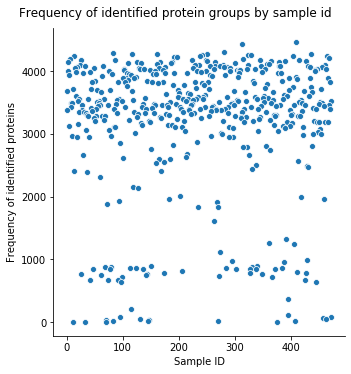

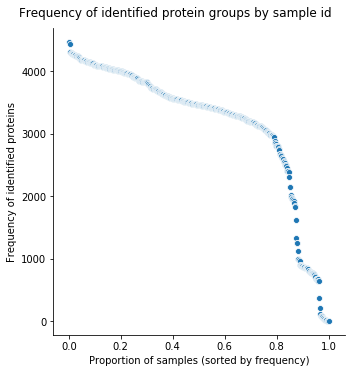

In [15]:
fig_ident_prot = sns.relplot(x='SampleID', y=COL_NO_IDENTIFIED_PROT, data=sample_stats) 
fig_ident_prot.set_axis_labels("Sample ID", "Frequency of identified proteins")
fig_ident_prot.fig.suptitle('Frequency of identified protein groups by sample id', y=1.03)
_savefig(fig_ident_prot, 'identified_proteins_by_sample')

fig_ident_prot_dist = sns.relplot(x=COL_PROP_SAMPLES, y=COL_NO_IDENTIFIED_PROT, data=sample_stats)
fig_ident_prot_dist.set_axis_labels("Proportion of samples (sorted by frequency)", "Frequency of identified proteins")
fig_ident_prot_dist.fig.suptitle('Frequency of identified protein groups by sample id', y=1.03)
_savefig(fig_ident_prot_dist, 'identified_proteins_ordered')

### Protein-Groups do not match well
- Are the assigned protein-group names sensible inbetween runs? 
    > Each sample has at least 80 percent missing values regarding all identified proteins
- Clustering by MaxQuant into protein-groups is sample dependent and therefore some groups might represent a very similar set of peptides

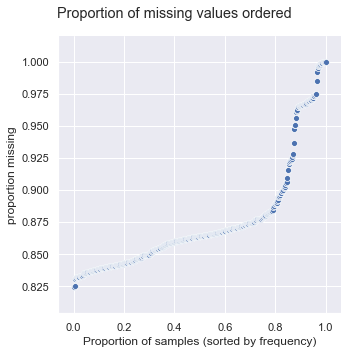

In [16]:
COL_NO_MISSING_PROT_PROP = COL_NO_MISSING_PROT + '_PROP'
sample_stats[COL_NO_MISSING_PROT_PROP]= sample_stats[COL_NO_MISSING_PROT] / float(X.shape[1])

# from ggplot import *
# ggplot(aes(x='nan_proc'), data = nonnan) + geom_histogram(binwidth = 0.005) #+ ylim(0,0.025)
sns.set(style="darkgrid")
g = sns.relplot(x='prop_samples', y=COL_NO_MISSING_PROT_PROP, data=sample_stats)
plt.subplots_adjust(top=0.9)
g.set_axis_labels("Proportion of samples (sorted by frequency)", "proportion missing")
g.fig.suptitle('Proportion of missing values ordered')
_savefig(g, "proportion_proteins_missing.pdf")

### Protein-Groups

In [17]:
protein_groups = X.columns.to_frame('proteins')

Some protein groups are ensembles?

In [18]:
protein_groups.proteins.str.len().sort_values()

proteins
X6RM59                              6
K7EQF5                              6
K7EQG1                              6
K7EQG9                              6
K7EQH1                              6
                                   ..
CON__ENSEMBL:ENSBTAP00000024462    31
CON__ENSEMBL:ENSBTAP00000032840    31
CON__ENSEMBL:ENSBTAP00000038329    31
CON__ENSEMBL:ENSBTAP00000001528    31
CON__ENSEMBL:ENSBTAP00000018229    31
Name: proteins, Length: 25427, dtype: int64

In [19]:
import ipywidgets as w
N=24
print(f'Top {N} grouped by first characters')
def calc_counts(n_characters):
    return protein_groups.proteins.str[:n_characters].value_counts()[:N]
w.interact(calc_counts, n_characters=w.IntSlider(value=4, min=1, max=10))

Top 24 grouped by first characters


interactive(children=(IntSlider(value=4, description='n_characters', max=10, min=1), Output()), _dom_classes=(…

<function __main__.calc_counts(n_characters)>

How does the naming work?

In [20]:
protein_groups['p4'] = protein_groups.proteins.str[:4]
protein_groups['p8'] = protein_groups.proteins.str[:8]
protein_groups['p9'] = protein_groups.proteins.str[:9]

In [21]:
protein_groups.sort_values('p8')

,proteins,p4,p8,p9
proteins,,,,
A0A024QZ33,A0A024QZ33,A0A0,A0A024QZ,A0A024QZ3
A0A024QZ42,A0A024QZ42,A0A0,A0A024QZ,A0A024QZ4
A0A024QZP7,A0A024QZP7,A0A0,A0A024QZ,A0A024QZP
A0A024QZX5,A0A024QZX5,A0A0,A0A024QZ,A0A024QZX
A0A024R161,A0A024R161,A0A0,A0A024R1,A0A024R16
...,...,...,...,...
X6RLL4,X6RLL4,X6RL,X6RLL4,X6RLL4
X6RLN4,X6RLN4,X6RL,X6RLN4,X6RLN4
X6RLR1,X6RLR1,X6RL,X6RLR1,X6RLR1


Prefixed `CON__` or `REV__`

In [22]:
protein_groups.loc[protein_groups.p4.isin(('CON_','REV_'))].sort_index()

,proteins,p4,p8,p9
proteins,,,,
CON__A2I7N0,CON__A2I7N0,CON_,CON__A2I,CON__A2I7
CON__A2I7N1,CON__A2I7N1,CON_,CON__A2I,CON__A2I7
CON__A2I7N3,CON__A2I7N3,CON_,CON__A2I,CON__A2I7
CON__ENSEMBL:ENSBTAP00000001528,CON__ENSEMBL:ENSBTAP00000001528,CON_,CON__ENS,CON__ENSE
CON__ENSEMBL:ENSBTAP00000006074,CON__ENSEMBL:ENSBTAP00000006074,CON_,CON__ENS,CON__ENSE
...,...,...,...,...
REV__Q96HY6,REV__Q96HY6,REV_,REV__Q96,REV__Q96H
REV__Q96HY6-2,REV__Q96HY6-2,REV_,REV__Q96,REV__Q96H
REV__Q96PE2,REV__Q96PE2,REV_,REV__Q96,REV__Q96P


## Select Proteins

### Minumum required sample quality
First define the minum requirement of a sample to be kept in 

In [23]:
import ipywidgets as w
MIN_DEPTH_SAMPLE = 1500
w_min_depth_sample = w.IntSlider(value=MIN_DEPTH_SAMPLE, min=0, max=max(sample_stats[COL_NO_IDENTIFIED_PROT]))
w_min_depth_sample

IntSlider(value=1500, max=4461)

In [24]:
mask_samples = sample_stats[COL_NO_IDENTIFIED_PROT] >= w_min_depth_sample.value
print(f"Selected {mask_samples.sum()} samples")

Selected 413 samples


In [25]:
# datasets with 50% and 90% coverage + log transformation, z-normalization and fill missingness (for pca)
x_50 = coverage(X.loc[mask_samples], coverage_col=0.5, coverage_row=0.2)
# x_50_pca = log_z_zeroone_na(x_50) # there is a huge difference if NA is set to low value or mean!!
x_90 = coverage(X.loc[mask_samples], 0.9, 0.9)
# x_90_pca = log_z_zeroone_na(x_90)

In [26]:
x_90.sample()

proteins,A0A075B736,A0A087WYC1,A0A0A0MSI0,A0A0B4J2C3,A0A0C4DGZ5,A0A0J9YXZ5,A0A140T936,A0A2R8Y6G6,A0A3B3IS95,A0A494C1A5,...,Q9NYU2,Q9UG63-2,Q9UIG0,Q9UQ80-2,Q9Y265-2,Q9Y2W1,Q9Y3A5,Q9Y3F4-2,Q9Y617-2,V9GYZ6
SampleID,,,,,,,,,,,,,,,,,,,,,
8,2.257000e+09,4.630300e+10,1.383400e+11,2.232300e+10,1.554300e+10,4.390000e+10,2.025100e+10,2.889800e+11,1.090300e+11,3.493700e+10,...,2.272000e+09,1.636800e+10,8.111000e+09,5.147400e+10,1.253200e+10,7.201600e+09,5.729700e+09,1.356700e+10,1.721900e+10,5.427000e+10


### Distribution of Intensity values
- comparing non-transformed to $\log_{10}$ transformed

Sample ID: 366


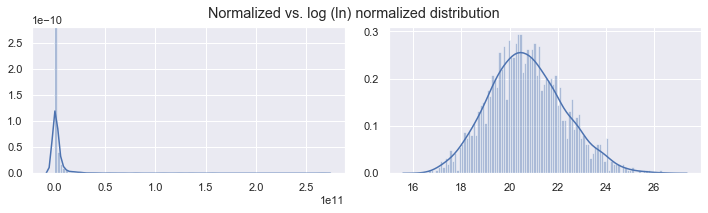

In [27]:
from vaep.transform import log
from random import sample
sample = x_50.sample()
sample_id = sample.index[0]
print("Sample ID:", sample_id)
sns.set(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(10,3))
sns.distplot(sample, bins=100, ax=axes[0])
sample_log = log(sample) # natural logarithm, could also be base_2, base_10 logarithm
sns.distplot(sample_log, bins=100, ax=axes[1])
_ = fig.suptitle("Normalized vs. log (ln) normalized distribution")
plt.tight_layout()
_savefig(fig, 'distribution_sample_' + str(sample_id))

ToDo: Select a logarithm for the transformation which is either interpretable or gives best to normal distribution:
1. $log_2$: Interpretable as continous doubling of the intensity
2. KDensity measure of goodness of fit to normal distribution.

In [28]:
x_50 = x_50.apply(log)
x_90 = x_90.apply(log)

In [29]:
x_50.head()

proteins,A0A075B6E2,A0A075B6F9,A0A075B6Q0,A0A075B736,A0A087WSY9,A0A087WTB8,A0A087WTW0,A0A087WUC6,A0A087WUE9,A0A087WUZ3,...,U3KQ85,V5IRT4,V9GYP5,V9GYY3,V9GYZ6,X6R8A1,X6RA14,X6RA30,X6RAC9,X6RFL8
SampleID,,,,,,,,,,,,,,,,,,,,,
408,23.308922,20.591288,18.533920,23.161081,22.947067,20.541624,20.204559,20.240315,20.737957,23.491972,...,19.931491,18.116395,21.109820,23.612748,23.453599,20.901161,21.535884,19.928905,20.952471,NaN
281,23.300296,20.422080,18.915926,23.133718,22.899255,20.769386,20.397771,20.534681,20.707055,23.667126,...,19.519326,17.810771,21.169361,23.753593,23.717998,20.958180,21.893951,19.753284,NaN,NaN
82,22.241750,NaN,NaN,22.498286,NaN,19.459437,18.806895,18.969438,19.873956,22.474429,...,20.963935,17.666934,NaN,NaN,22.381437,19.978657,NaN,18.560182,NaN,NaN
161,22.241465,NaN,NaN,22.683572,NaN,19.933145,18.912018,NaN,19.671671,22.149430,...,NaN,NaN,20.086215,NaN,22.413638,19.699251,NaN,18.398496,NaN,NaN
251,20.808342,NaN,18.821200,22.698971,NaN,20.193631,19.569891,NaN,20.333197,NaN,...,NaN,18.384494,NaN,23.117336,22.467130,20.543469,NaN,19.538115,NaN,NaN


## Imputing missing values in log-transformed space

Options:
1. Mean Imputation
2. Zero Imputation
2. Shifted Mean Imputation (and randomization)

In [30]:
from vaep.imputation import imputation_normal_distribution
_manuael_imputed = imputation_normal_distribution(x_50.iloc[:,0])
_applied_imputed = x_50.iloc[:,:3].apply(imputation_normal_distribution).iloc[:,0]
assert _manuael_imputed.equals(_applied_imputed), "You got apply wrong"

In [31]:
from vaep.imputation import imputation_normal_distribution
x_50 = x_50.apply(imputation_normal_distribution)
x_90 = x_90.apply(imputation_normal_distribution)

In [32]:
from config import PROCESSED_DATA, PREFIX_IMPUTED, PREFIX_META
x_50.to_pickle(os.path.join(PROCESSED_DATA, PREFIX_IMPUTED+'_50.pkl'))
x_90.to_pickle(os.path.join(PROCESSED_DATA, PREFIX_IMPUTED+'_90.pkl'))

In [33]:
labels.to_pickle(os.path.join(PROCESSED_DATA, PREFIX_META + '.pkl'))